In [23]:
import pandas as pd
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib.ticker as ticker
import itertools
import math

In [2]:
path = "/home/francisco/tps/datos/tp2/"
load_path = path + "{}.hdf"

N_P = 2
N_S = 2
pacientes_P = []
pacientes_S = []
for load_name, N, dest in [("P", N_P, pacientes_P), ("S", N_S, pacientes_S)]:
    for paciente in [load_name + "{:02d}".format(i) for i in range(1, 1 + N)]:
        dest.append(pd.read_hdf(load_path.format(paciente)))


a1

In [ ]:
dfs1 = [pacientes_P[i].loc[i+1,:,[8,44,80,131,185],:] for i in range(N)]

In [ ]:
sensor_means = [df.groupby(['epoch', 'tiempo']).mean() for df in dfs1]

In [ ]:
for sm in sensor_means:
    frecuencias = sm.groupby(['epoch']).apply(lambda x: scipy.signal.welch(x['valores'], fs=100, nperseg = 200))
    data = {'epoch {}'.format(i): f for i,f in enumerate(map(lambda x: x[1], frecuencias.values))}
    index = frecuencias.values[0][0]
    f_df = pd.DataFrame(data=data, index=index)
    
    g = sns.heatmap(f_df, xticklabels=175, yticklabels=10, robust=True)
    sns.plt.show()


a2

In [ ]:
epoch_means = [df.groupby(['sensor', 'tiempo']).mean() for df in pacientes_P]

In [ ]:
for em in epoch_means:
    for sensor, df_g in em.groupby(['sensor']):
        f, P = scipy.signal.welch(df_g['valores'].values, nperseg=201)
        sns.plt.plot(f, P)
    axes = sns.plt.gca()
    axes.set_ylim([0,10**-10])
    sns.plt.show()

b <b>No entiendo porque los valores de f quedan entre 0 y 0.5 en lugar de quedar entre 0 y 50</b>

In [3]:
def calcular_frecuencias(f, P):
    return {
        'delta': P[f<0.04].sum(),
        'theta': P[(0.04<=f) & (f<0.08)].sum(),
        'alpha': P[(0.08<=f) & (f<0.13)].sum(),
        'beta': P[(0.13<=f) & (f<0.30)].sum(),
        'gamma': P[0.30<=f].sum()
    }
    

bandas_P = []
bandas_S = []
for bandas, pacientes in [(bandas_P, pacientes_P), (bandas_S, pacientes_S)]:
    for i, p in enumerate(pacientes):
        frecuencia_media = p.groupby(['tiempo']).mean()
        f, P = scipy.signal.welch(frecuencia_media['valores'], nperseg=201)
        bandas.append(calcular_frecuencias(f,P))



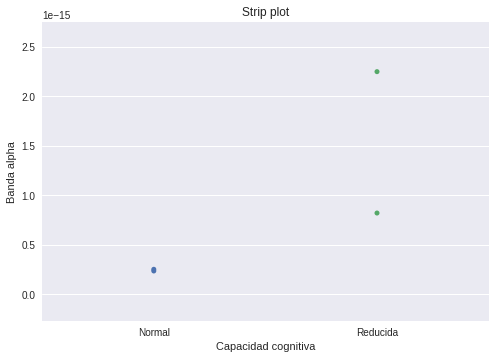

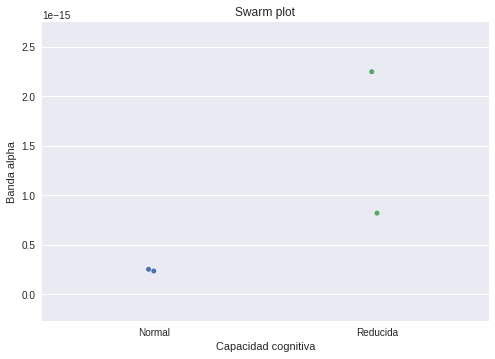

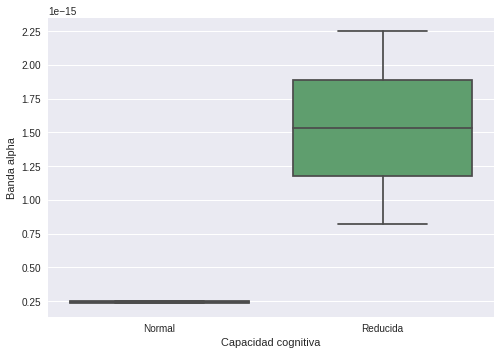

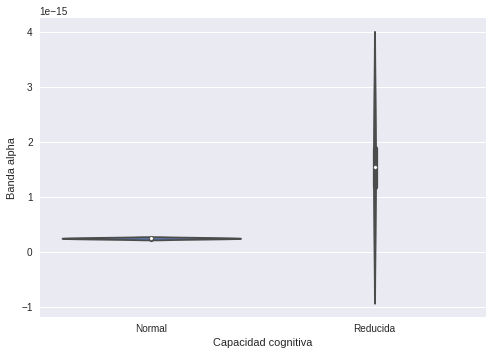

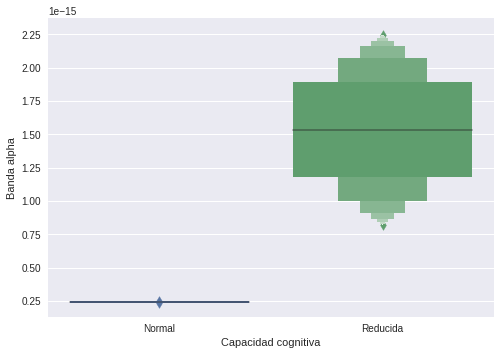

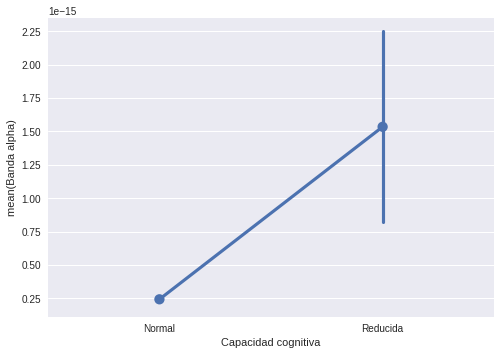

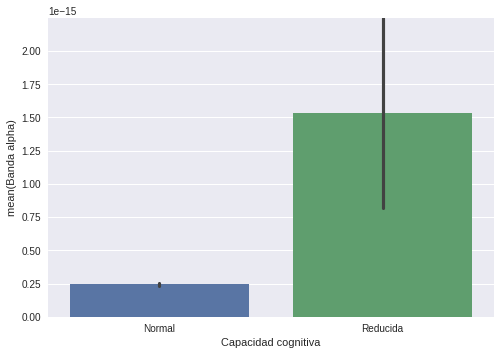

In [4]:
df_bandas = pd.DataFrame({
    "Capacidad cognitiva": (["Normal"] * N_S) + (["Reducida"] * N_P),
    "Banda delta": [d['delta'] for d in bandas_S + bandas_P],
    "Banda theta": [d['theta'] for d in bandas_S + bandas_P],
    "Banda alpha": [d['alpha'] for d in bandas_S + bandas_P],
    "Banda beta": [d['beta'] for d in bandas_S + bandas_P],
    "Banda gamma": [d['gamma'] for d in bandas_S + bandas_P],
})

ymin = min(df_bandas['Banda alpha'])
ymax = max(df_bandas['Banda alpha'])
decimo = (ymax - ymin)/len(df_bandas['Banda alpha'])
ymin, ymax = ymin - decimo, ymax + decimo

ax = sns.stripplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_ylim([ymin, ymax])
ax.set_title("Strip plot")
sns.plt.show()

ax = sns.swarmplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_ylim([ymin, ymax])
ax.set_title("Swarm plot")
sns.plt.show()

sns.boxplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Box plot")
sns.plt.show()

sns.violinplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Violin plot")
sns.plt.show()

sns.lvplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Lette value plot")
sns.plt.show()

sns.pointplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Point plot")
sns.plt.show()

sns.barplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Bar plot")
sns.plt.show()



Se decide utilizar una combinación de violinplot y de swarmplot. El primero permite entender la distribución de los elementos, mientras que con el segundo se ven los valores puntuales.

In [5]:
def calcular_delta(d,e):
    mean_1_inicial = d[e == e[0]].mean()
    mean_2_inicial = d[e != e[0]].mean()
    return mean_2_inicial - mean_1_inicial


def permutation_test(d,e, n=100):
    d0 = calcular_delta(d, e)
    deltas = np.zeros(n)
    aux_e = e.copy()

    for i in range(n):
        np.random.shuffle(aux_e)
        deltas[i] = calcular_delta(d,aux_e)

    return deltas, d0

def foo(a, e_a, b, e_b):
    e_1 = np.full(a.shape[0], e_a) 
    e_2 = np.full(b.shape[0], e_b)
    e = np.concatenate((e_1, e_2)) 
    d = np.concatenate((a,b))
    return d,e

def test_permutacion(soleado, lluvioso):
    d, e = foo(soleado, 's', lluvioso, 'l')

    # delta-value : la diferencia entre las medias que presenta nuestra información 
    # p-value es la probabilidad de haber obtenido este delta o mayor

    deltas, delta_value = permutation_test(d,e)
    p_value =  deltas[deltas >= delta_value].shape[0]/deltas.shape[0]

    return p_value
    #printnt("Delta-value = {} | p-value = {}".format(delta_value, p_value))

    # Delta-level : el delta que atrapa el percentil 1-'alpha-level' de la distribución
    # Nuestro Delta-value debería caer antes de a esto para no rechazar H0
    delta_level = np.percentile(deltas, 95)

    fig = sns.plt.figure(dpi=100)
    sns.plt.axes().set_title('Test de Permutaciones', fontsize=20)
    sns.plt.axes().set_xlabel('Delta', fontsize=14) 
    sns.plt.axes().set_ylabel('# Repeticiones', fontsize=14) 

    sns.distplot(deltas, norm_hist=False, kde=False)
    sns.plt.axvline(x=delta_value, linewidth=1, color='red', linestyle="dotted", label="d-value")
    sns.plt.axvline(x=delta_level, linewidth=1, color='g', linestyle="dotted", label="d-level")
    
    sns.plt.legend()

    #Cuadro para printear valores
    textstr = "d-value : {} \n p-value : {} \n d-level : {}".format(round(delta_value,3),round(p_value,3),round(delta_level,3))
    props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
    sns.plt.axes().text(0.97, 0.5, textstr, fontsize=10,verticalalignment='center', bbox=props)

    sns.plt.show()
    

def analisis_comparativo(df_b):
    ymin = min(df_b['Potencia'])
    ymax = max(df_b['Potencia'])
    decimo = (ymax - ymin)/len(df_b['Potencia'])
    ymin, ymax = ymin - decimo, ymax + decimo

    # Despues veo con cual quedarme
    # Hay que tener en cuenta que son pocos valores

    sns.violinplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2", inner="stick", cut=0)
    sns.plt.show()


    ax = sns.swarmplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2")
    ax.set_ylim([ymin, ymax])
    sns.plt.show()


    sns.barplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b, palette="Set2")
    ax = sns.swarmplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", split=True, data=df_b, palette="Set2")
    ax.set_ylim([ymin, ymax])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2])
    sns.plt.show()
    
    print("Probabilidad de que tengan la misma media ambos grupos para:")
    p_values = {}            
    for banda in ["delta", "theta", "alpha", "beta", "gamma"]:
        p_values[banda] = \
            test_permutacion(df_b[(df_b['Banda'] == banda) & (df_b['Capacidad cognitiva'] == "Reducida")]['Potencia'],
                             df_b[(df_b['Banda'] == banda) & (df_b['Capacidad cognitiva'] == "Normal")]['Potencia'])
        print("\t- para la banda {}: {}".format(banda, p_values[banda]))
        
def normalizar_banda(df_):
    min_pot = min(df_['Potencia'])
    max_pot = max(df_['Potencia'])
    
    df_["Potencia"] = (df_["Potencia"] - min_pot) / (max_pot - min_pot)
    
    return df_
    

In [6]:
df_bandas = pd.DataFrame({
    "Capacidad cognitiva": (["Reducida"] * (N_P * 5)) + (["Normal"] * (N_S * 5)),
    "Banda": list(itertools.chain(*[list(d.keys()) for d in bandas_P + bandas_S])),
    "Potencia": list(itertools.chain(*[list(d.values()) for d in bandas_P + bandas_S]))
})
df_bandas_normalizadas = df_bandas.groupby(['Banda']).apply(normalizar_banda)


Análisis comparativo para las distintas bandas:


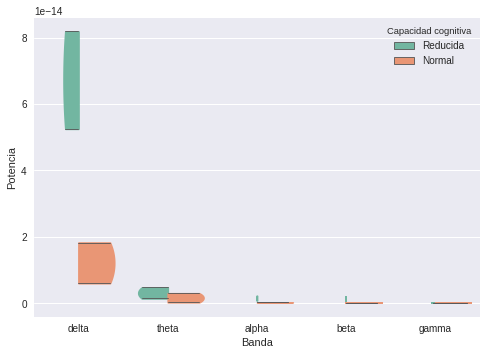

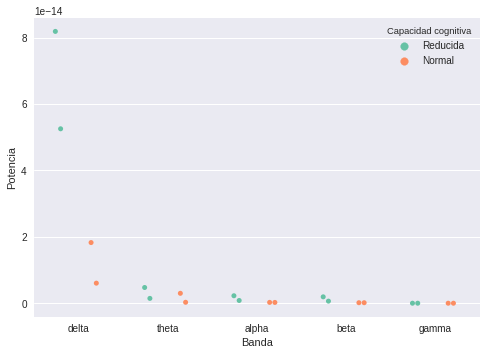

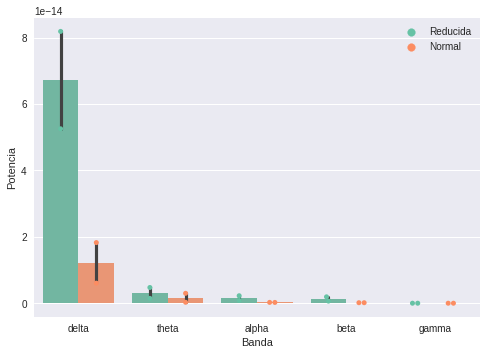

Probabilidad de que tengan la misma media ambos grupos para:
	- para la banda delta: 1.0
	- para la banda theta: 0.61
	- para la banda alpha: 1.0
	- para la banda beta: 1.0
	- para la banda gamma: 0.35
------------
Análisis comparativo para las distintas bandas:


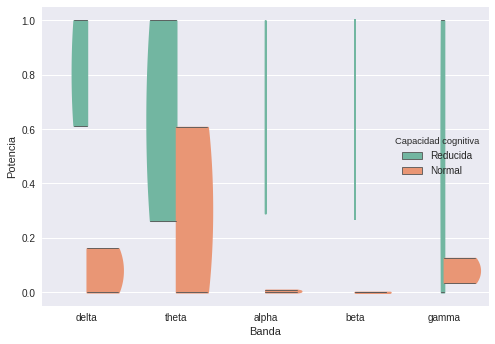

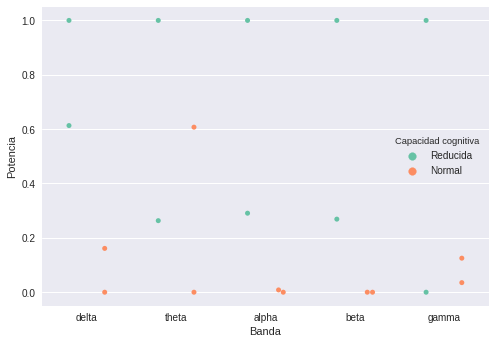

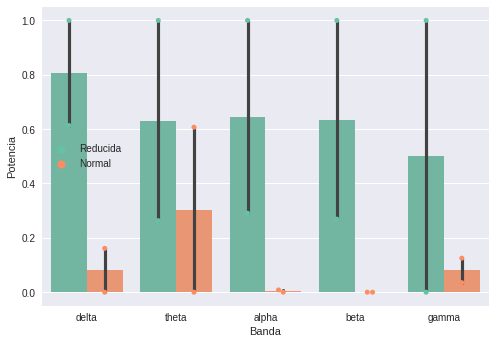

Probabilidad de que tengan la misma media ambos grupos para:
	- para la banda delta: 1.0
	- para la banda theta: 0.62
	- para la banda alpha: 1.0
	- para la banda beta: 1.0
	- para la banda gamma: 0.36


In [7]:
print("Análisis comparativo para las distintas bandas:")
analisis_comparativo(df_bandas)
print("------------", "Análisis comparativo para las distintas bandas:", sep="\n")
analisis_comparativo(df_bandas_normalizadas)



2

In [22]:
df_reducido = pacientes_P[0].loc[1,:2,:2,:]
df_reducido

valores
paciente epoch sensor tiempo              
1        0     0      0       9.501905e-06
                      1       5.574281e-06
                      2       5.157830e-06
                      3       6.594364e-06
                      4       7.073382e-06
                      5       5.532860e-06
                      6       3.260051e-06
                      7       2.008014e-06
                      8       1.928786e-06
                      9       1.516837e-06
                      10     -5.582674e-07
                      11     -3.786575e-06
                      12     -6.012345e-06
                      13     -5.205970e-06
                      14     -1.156956e-06
                      15      4.190507e-06
                      16      7.773867e-06
                      17      7.083312e-06
                      18      1.734859e-06
                      19     -5.729042e-06
                      20     -1.058215e-05
                      21     -8.510794e-06
                      22      1.047599e-06
                      23      1.330091e-05
                      24      2.028588e-05
                      25      1.620793e-05
                      26      2.240605e-06
                      27     -1.339888e-05
                      28     -2.096848e-05
                      29     -1.637994e-05
...                                    ...
         2     2      171    -3.444132e-05
                      172    -3.199682e-05
                      173    -3.023747e-05
                      174    -2.902823e-05
                      175    -2.773611e-05
                      176    -2.620190e-05
                      177    -2.499368e-05
                      178    -2.474907e-05
                      179    -2.539755e-05
                      180    -2.612170e-05
                      181    -2.607631e-05
                      182    -2.510606e-05
                      183    -2.377393e-05
                      184    -2.275295e-05
                      185    -2.223443e-05
                      186    -2.191530e-05
                      187    -2.150991e-05
                      188    -2.121101e-05
                      189    -2.159011e-05
                      190    -2.300411e-05
                      191    -2.508684e-05
                      192    -2.683110e-05
                      193    -2.720546e-05
                      194    -2.580259e-05
                      195    -2.309207e-05
                      196    -2.022902e-05
                      197    -1.858421e-05
                      198    -1.913373e-05
                      199    -2.186888e-05
                      200    -2.556665e-05

[1809 rows x 1 columns]

In [40]:
# Transformación simbolica
def transformacion_simbolica(df_):
    sigma = df_['valores'].std()
    min_v = min(df_['valores'])
    max_v = max(df_['valores'])
    
    # Calculo el N
    N = math.ceil((max_v - min_v) / (3.5 * sigma * len(df_['valores'])**(-1/3)))
    
    # Divido los valores en N rangos
    step = (max_v - min_v) / N
    ranges = []
    k = min_v
    for i in range(N):
        ranges.append((k, k + step))
        k += step
        
    ranges[-1] = (ranges[-1][0], ranges[-1][1] + step)
    apariciones = pd.Series([len(df_[(c_inf <= df_['valores']) & (df_['valores'] < c_sup)]) for c_inf, c_sup in ranges])
    
    df_t = pd.DataFrame({"cantidades": apariciones}) 
    return df_t
    
        

df_t = df_reducido.groupby(["paciente", "epoch", "sensor"]).apply(transformacion_simbolica)
new_names = list(df_t.index.names)
new_names[3] = "simbolo"
df_t.index.names = new_names




                         cantidades
paciente epoch sensor              
1        0     0      0          20
                      1          67
                      2          47
                      3           6
                      4          27
                               cantidades
paciente epoch sensor simbolo            
1        0     0      0                20
                      1                67
                      2                47
                      3                 6
                      4                27
Index(['cantidades'], dtype='object')
